In [1]:
import pandas as pd

In [ ]:
# Display all available columns in the dataframes
pd.set_option("display.max_columns", None)

### load TBS dataset to be mapped

In [114]:
unmapped_df = pd.read_csv('Reference_results_UNmapped_TBS_products_with_OBD_genericUUIDs.csv', low_memory=False)

print(unmapped_df.shape)
unmapped_df.head(1)

(260, 11)


,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,NaN,NaN,NaN,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.0


### load OBD datasets to be used for the mapping

In [3]:
obd_2020_df = pd.read_csv(r'C:\Users\Nutzer\OneDrive\CodeAcademyBerlin_Projects\N3XTCODER_AI4Impact\Data\OBD\OBD_2020_II.csv',
                            sep=';', encoding='ISO-8859-1', low_memory=False)
obd_2023_df = pd.read_csv(r'C:\Users\Nutzer\OneDrive\CodeAcademyBerlin_Projects\N3XTCODER_AI4Impact\Data\OBD\OBD_2023_I.csv',
                            sep=';', encoding='ISO-8859-1', low_memory=False)
obd_2024_df = pd.read_csv(r'C:\Users\Nutzer\OneDrive\CodeAcademyBerlin_Projects\N3XTCODER_AI4Impact\Data\OBD\OBD_2024_I.csv',
                            sep=';', encoding='ISO-8859-1', low_memory=False)

# Filter for only "generic dataset" entries
generic_2020 = obd_2020_df[obd_2020_df['Typ'] == 'generic dataset']
generic_2023 = obd_2023_df[obd_2023_df['Typ'] == 'generic dataset']
generic_2024 = obd_2024_df[obd_2024_df['Typ'] == 'generic dataset']

# Combine all generic materials into one DataFrame
generic_all_years_df = pd.concat([generic_2020, generic_2023, generic_2024], ignore_index=True)

# Optional: Save it to a CSV for review
# generic_all_years_df.to_csv("generic_materials_combined.csv", index=False, sep=';')

# Print summary
print("Total generic materials:", len(generic_all_years_df))
print(generic_all_years_df[['UUID', 'Name (en)', 'Typ']].head())

Total generic materials: 7991
                                   UUID                             Name (en)  \
0  fa5119d5-b0b8-4774-9c23-928f6894bd50             Electricity grid mix 2018   
1  a4fb9ec0-d5ae-414b-a0a1-2cf7f586022d  Precast concrete slab, ceiling, 40cm   
2  3470c523-ffcd-48df-93ff-dedfde86572a     Precast concrete slab, wall, 40cm   
3  ffff2074-fae0-4b5c-b801-af80f5ce633a                           Cable CAT 7   
4  ffff2074-fae0-4b5c-b801-af80f5ce633a                           Cable CAT 7   

               Typ  
0  generic dataset  
1  generic dataset  
2  generic dataset  
3  generic dataset  
4  generic dataset  


### select method for vectors or embeddings

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [115]:
# Fill nulls
generic_all_years_df['Name (en)'] = generic_all_years_df['Name (en)'].fillna('')
generic_all_years_df['Bezugseinheit'] = generic_all_years_df['Bezugseinheit'].fillna('')
generic_all_years_df['Referenzjahr'] = pd.to_numeric(generic_all_years_df['Referenzjahr'], errors='coerce')

unmapped_df['productName'] = unmapped_df['productName'].fillna('')
unmapped_df['tBaustoffVersion'] = unmapped_df['tBaustoffVersion'].fillna('2024-Q4')  # Simulated fallback
unmapped_df['version_year'] = unmapped_df['tBaustoffVersion'].str.extract(r'(\d{4})').astype(float)

In [116]:
# Vectorize names
name_vectorizer = TfidfVectorizer().fit(
    generic_all_years_df['Name (en)'].tolist() + unmapped_df['productName'].tolist()
)
generic_vectors = name_vectorizer.transform(generic_all_years_df['Name (en)'])

In [117]:
# Loop through each unmapped entry
matches = []

for idx, row in unmapped_df.iterrows():
    specific_name = row['productName']
    year = row['version_year']
    unit = 'kg'  # Simulated; replace if actual value available

    specific_vector = name_vectorizer.transform([specific_name])
    name_similarities = cosine_similarity(specific_vector, generic_vectors).flatten()

    temp_df = generic_all_years_df.copy()
    temp_df['Specific_Name'] = specific_name
    temp_df['Name_Similarity'] = name_similarities
    temp_df['Year_Match'] = temp_df['Referenzjahr'].apply(lambda x: 1 if pd.notna(x) and abs(x - year) <= 2 else 0)
    temp_df['Unit_Match'] = (temp_df['Bezugseinheit'] == unit).astype(int)

    temp_df['Final_Score'] = (
        0.4 * temp_df['Name_Similarity'] +
        0.1 * temp_df['Year_Match'] +
        0.2 * temp_df['Unit_Match']
    )

    top_match = temp_df.sort_values(by='Final_Score', ascending=False).head(1)
    matches.append(top_match)

In [118]:
# Combine results
top_matches_df = pd.concat(matches, ignore_index=True)

In [119]:
# display final results
top_matches_df_2=top_matches_df[['Specific_Name', 'UUID', 'Name (en)', 'Name_Similarity', 'Year_Match', 'Unit_Match', 'Final_Score']]
top_matches_df_2.sort_values(by='Final_Score', ascending=False)

,Specific_Name,UUID,Name (en),Name_Similarity,Year_Match,Unit_Match,Final_Score
47,PVC Plastisol,658b2d08-fd24-4d43-a469-203d594b2278,PVC Plastisol,1.000000,1,1,0.700000
78,Sand 0/2,286b0072-1001-4e5f-baa2-282230755243,Sand 0/2,1.000000,1,1,0.700000
44,"Bitumen Emulsion (40% Bitumen, 60% Wasser)",88c0f648-2316-4bbc-99b3-dbc636580088,"Bitumen emulsion (40% bitumen, 60% water)",0.829710,1,1,0.631884
37,Blähton Sand,286b0072-1001-4e5f-baa2-282230755243,Sand 0/2,0.572326,1,1,0.528931
79,Sand 0/2 getrocknet,286b0072-1001-4e5f-baa2-282230755243,Sand 0/2,0.572326,1,1,0.528931
...,...,...,...,...,...,...,...
108,EPS-Hartschaumdämmung - Sz. RC als Schütt.,8f4e4fdb-fa6c-46b3-8680-57120c4bee5e,"Cement (CEM III 42,5)",0.000000,1,1,0.300000
109,Expandierter Kork,8f4e4fdb-fa6c-46b3-8680-57120c4bee5e,"Cement (CEM III 42,5)",0.000000,1,1,0.300000
110,XPS-Dämmstoff,8f4e4fdb-fa6c-46b3-8680-57120c4bee5e,"Cement (CEM III 42,5)",0.000000,1,1,0.300000
111,Faserverstärkte Spachtelmasse,8f4e4fdb-fa6c-46b3-8680-57120c4bee5e,"Cement (CEM III 42,5)",0.000000,1,1,0.300000


### Assessment

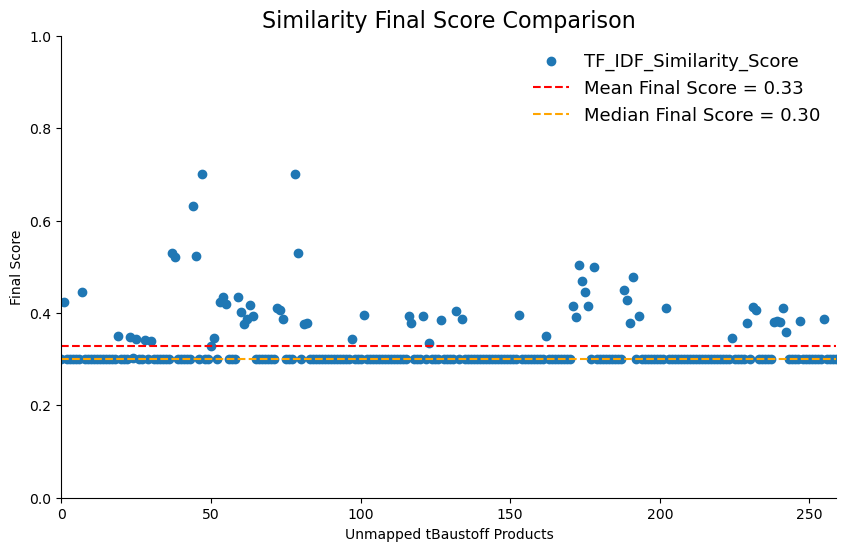

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.scatter(top_matches_df_2.index, top_matches_df_2['Final_Score'], label=f'TF_IDF_Similarity_Score')
# plt.plot(combined_Similarity_Score.index,  combined_Similarity_Score['TF_IDF_Similarity_Score'])

# Calculate the mean of y-values
mean_y = np.mean(top_matches_df_2['Final_Score'])
median_y = np.median(top_matches_df_2['Final_Score'])

# Add a horizontal line at the mean of y
plt.axhline(y=mean_y, color='r', linestyle='--', label=f'Mean Final Score = {mean_y:.2f}')
plt.axhline(y=median_y, color='orange', linestyle='--', label=f'Median Final Score = {median_y:.2f}')

# Set the x-axis range to start from 0
plt.xlim(0, len(top_matches_df_2) - 1)  # Assuming your index starts from 0
# Set the y-axis range to 0 and 1
plt.ylim(0, 1)

# Get the current axes object
ax = plt.gca()
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Font sizes for various elements
legend_fontsize = 13
title_fontsize = 16
axes_fontsize = 10

# Label the axes
plt.xlabel("Unmapped tBaustoff Products", fontsize=axes_fontsize)
plt.ylabel("Final Score", fontsize=axes_fontsize)

# Add a title
plt.title("Similarity Final Score Comparison", fontsize=title_fontsize)

# Add a legend to distinguish the lines
plt.legend(fontsize=legend_fontsize, frameon=False)

In [120]:
# calculate overall score for the method
overall_score_mean = top_matches_df_2['Final_Score'].mean()
overall_score_median = top_matches_df_2['Final_Score'].median()

print('Final score mean =',overall_score_mean)
print('Final score median =',overall_score_median)

Final score mean = 0.3292618519055585
Final score median = 0.30000000000000004


### compare matching with reality

In [ ]:
Reference_Mapped_df = pd.read_csv('Reference_results_mapped_TBS_products_with_OBD_genericUUIDs.csv', low_memory=False)
print(Reference_Mapped_df.shape)
Reference_Mapped_df.head(1)

(698, 11)


,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,3b1f0c75-07a4-4182-b310-5529fc5b54a6,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.0


In [159]:
# map OBD into TBS
combined_Reference_Mapped_df_with_matching = Reference_Mapped_df.merge(top_matches_df_2, left_on=['productName'], right_on=['Specific_Name'], how='left')
print(combined_Reference_Mapped_df_with_matching.shape)
combined_Reference_Mapped_df_with_matching.head(1)

(698, 18)


,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor,Specific_Name,UUID,Name (en),Name_Similarity,Year_Match,Unit_Match,Final_Score
0,3b1f0c75-07a4-4182-b310-5529fc5b54a6,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.0,Acetyliertes Holz,8f4e4fdb-fa6c-46b3-8680-57120c4bee5e,"Cement (CEM III 42,5)",0.0,1,1,0.3


In [158]:
# 
print('rows to map',combined_Reference_Mapped_df_with_matching['productName'].count())
print('unique UUID assigned',combined_Reference_Mapped_df_with_matching['UUID'].nunique())

# matched UUID Vs Real Mapping
combined_Reference_Mapped_df_with_matching['UUID_matched'] = combined_Reference_Mapped_df_with_matching['UUID']==combined_Reference_Mapped_df_with_matching['oekobaudatProcessUuid']
match_count=combined_Reference_Mapped_df_with_matching[combined_Reference_Mapped_df_with_matching['UUID_matched']==True]
print('matched UUID equal to Reality',len(match_count))
print('Success Matching Rate',len(match_count)/combined_Reference_Mapped_df_with_matching['productName'].count())

rows to map 698
unique UUID assigned 44
matched UUID equal to Reality 20
Success Matching Rate 0.02865329512893983


### considerations:

in OBD datasets = remove UUIDs already found in TBS to avoid mapping the same UUID to different products in TBS 
During Mapping = we should ensure that the same UUID is not mapped more than once